In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from dependencies import Dependencies
from parse import Parse

from datetime import datetime as dt

import os
key = os.environ.get('quandl_api_key')

import quandl
quandl.ApiConfig.api_key = key

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm

C:\Users\JB\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### OBJECTIVE

Investigate seasonal changes in WTI Crude and conversion to a potential alpha

TODO: 
1. Get an overview on average monthly change, grouped by month. 
2. Get an overview on average daily change, grouped by month. This should mirror the monthly change. 
3. Investigate probability distributions of the daily change per month. Ideally, a Gaussian Distribution would suggest that 
price movements during the specified period would be relatively stable.
4. Time Series breakdown on seasonality, stationarity. 
5. Create a backtest profile on based on monthly and daily changes. Calculate returns, and drawdown
6. Decide on limiting drawdown, by capping losses based on mean % loss for wrong trades. 
7. Summarize by creating a table on average daily returns. 

#### GETTING DATA FROM FRED VIA THE QUANDL API

In [2]:
crude_d = quandl.get('FRED/DCOILWTICO')
crude_mon = quandl.get('FRED/DCOILWTICO', collapse = 'monthly')
crude_mon.columns = ['Close']
crude_mon['pct_change'] = crude_mon['Close'].pct_change() * 100
crude_mon = crude_mon.dropna()

In [3]:
crude_mon = crude_mon.reset_index()
crude_mon['month'] = crude_mon['Date'].dt.month

In [4]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
crude_mon['month'] = crude_mon['month'].map({i + 1 : m for i, m in enumerate(months)})
crude_mon = crude_mon.set_index('Date')

In [5]:
crude_mon_pct = crude_mon.drop('Close', axis = 1)
crude_mon_pct

,pct_change,month
Date,,
1986-02-28,-30.184697,Feb
1986-03-31,-22.524565,Mar
1986-04-30,30.536585,Apr
1986-05-31,6.875934,May
1986-06-30,-10.489510,Jun
...,...,...
2022-01-31,18.359219,Jan
2022-02-28,7.817407,Feb
2022-03-31,4.577135,Mar


#### AVERAGE MONTHLY CHANGE

[Oil Seasonality](https://finance.yahoo.com/news/seasonality-impacts-crude-oil-prices-130529881.html)

Monthly change is calculated by calling the pct_change function, grouping the data by month, and calculating the mean. 

RATIONALE: 
Seasonality plays a key role in influencing crude oil prices. They tend to rise in August due to the summer driving season, fueling demand in gasoline, and tend to peak towards winter due to sluggish demand. Therefore, the tendency is for oil to become more expensive during seasons with high demand, and become cheaper on seasons with low demand (October - December).

Text(0.5, 0, 'Month')

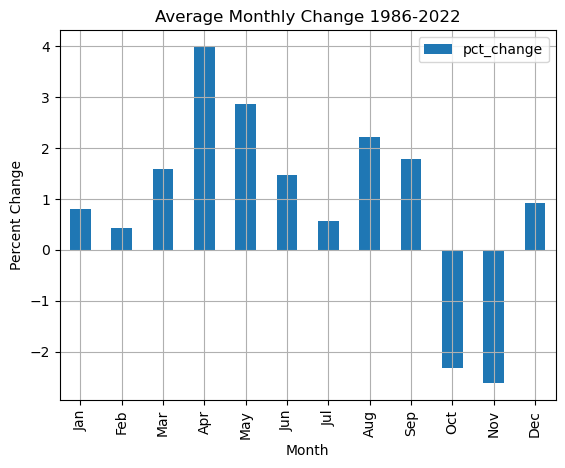

In [6]:
grouped = crude_mon_pct.groupby('month').mean().reindex(months)
grouped.plot(kind = 'bar', grid = True, title = 'Average Monthly Change 1986-2022')
plt.ylabel('Percent Change')
plt.xlabel('Month')

#### OBSERVATION 

The validity of seasonal changes in crude oil can be seen in the figure above, where it shows a negative average monthly change during winter season (October - November)

#### AVERAGE DAILY CHANGE

Average Daily change is calculated in a similar fashion to Monthly change. 

In [7]:
crude_d.columns = ['Close']
crude_d['pct_change'] = crude_d['Close'].pct_change() * 100
crude_d = crude_d.dropna()
crude_d = crude_d.reset_index()
crude_d['month'] = crude_d['Date'].dt.month

crude_d['month'] = crude_d['month'].map({i + 1 : m for i, m in enumerate(months)})
crude_d = crude_d.set_index('Date')

crude_d_pct = crude_d.drop('Close', axis = 1)

,Close,pct_change,month
Date,,,
2020-04-20,-36.98,-301.966139,Apr


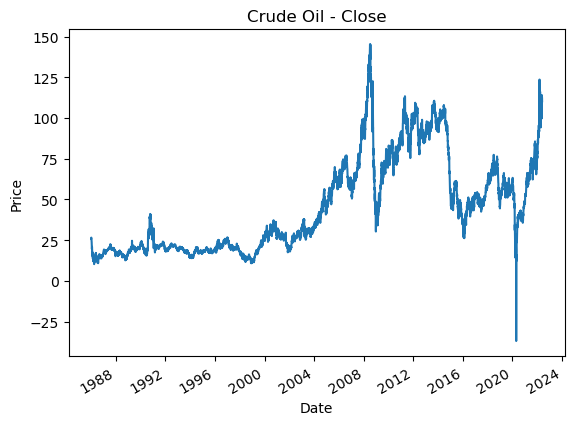

In [8]:
crude_d['Close'].plot()
plt.title('Crude Oil - Close')
plt.ylabel('Price')
crude_d.loc[crude_d['Close'] < 0]

#### ELIMINATING OUTLIERS

On April 20, 2020, Crude Oil closed at -36.98 USD, also known as the Great Oil Crash of 2020 was the first time Oil closed below 0. Would recommend to eliminate this since it does not constitute normal supply and demand conditions. 

Testing period would exclude 2020 onwards. 

Text(0, 0.5, 'Price')

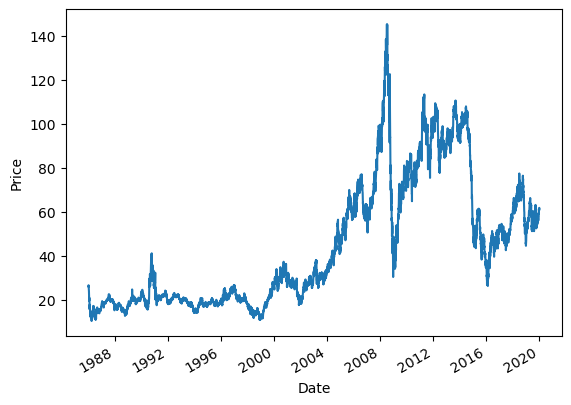

In [9]:
filtered_crude_d = crude_d[:8568].copy()
filtered_crude_d_pct = filtered_crude_d.drop('Close', axis = 1)
filtered_crude_d['Close'].plot()
plt.ylabel('Price')

Text(0.5, 0, 'Month')

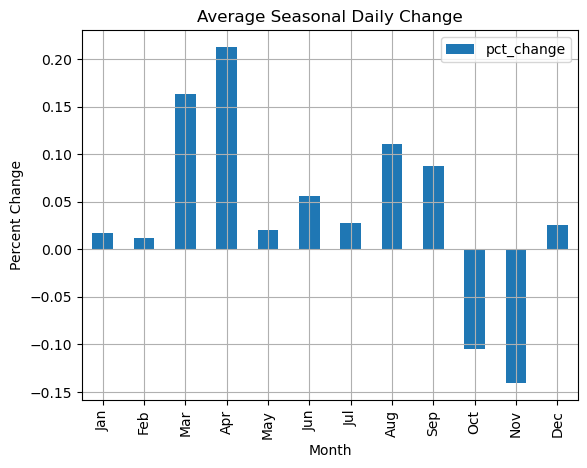

In [10]:
grouped_d = filtered_crude_d_pct.groupby('month').mean().reindex(months)
grouped_d.plot(kind = 'bar', grid = True, title = 'Average Seasonal Daily Change')
plt.ylabel('Percent Change')
plt.xlabel('Month')

#### VOLATILITY

Volatility is observed to range between 2% to 4% for the duration of the whole year, except for the April reading where, due to the Flash Crash of Covid, displays relatively high volatility.

Text(0.5, 0, 'Month')

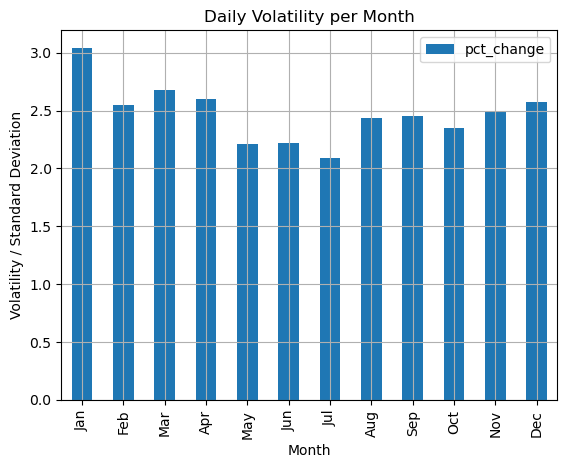

In [11]:
volatility_d = filtered_crude_d_pct.groupby('month').std().reindex(months)
volatility_d.plot(kind = 'bar', grid = True, title = 'Daily Volatility per Month')
plt.ylabel('Volatility / Standard Deviation')
plt.xlabel('Month')

### OBSERVATION

Investigating different time horizons shows relatively consistent results.

Other events that can affect oil prices would be geopolitical tensions, economic slowdown, financial crisis, war. 

#### ASSESSING THE PROBABILITY DISTRIBUTION OF AVERAGE DAILY CHANGE

For the entire dataset, the distribution of daily change appears to be a Gaussian Distribution, however, highly concentrated around 0. 

The figures reflect the measure of volatility from the previous figure. 

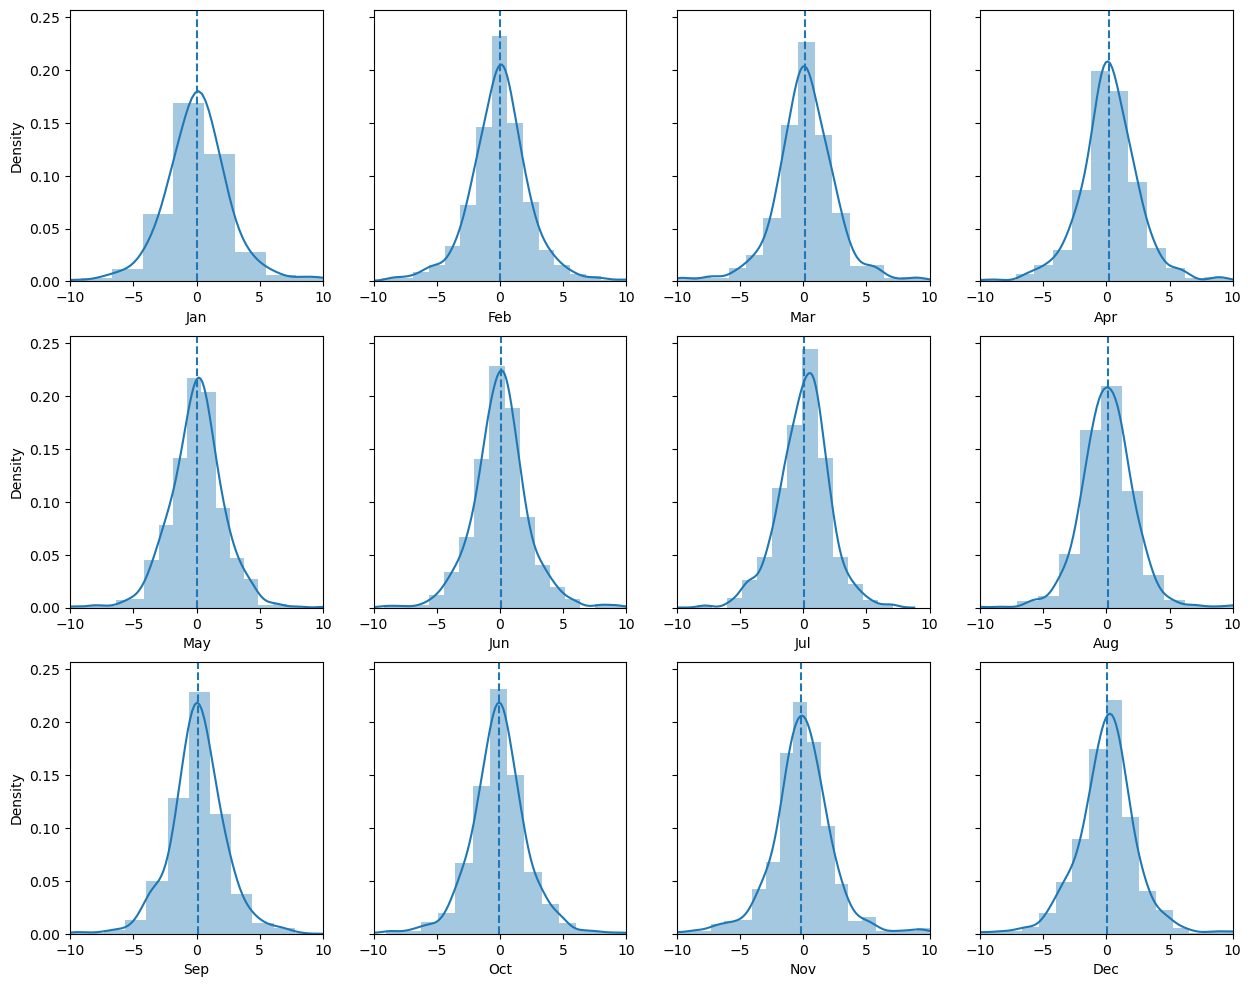

In [12]:
fig, axes = plt.subplots(3, 4, sharey = True, sharex = False, figsize = (15, 12))
#plt.setp(ax, xlim=(-10, 10))
jan = filtered_crude_d.loc[filtered_crude_d['month'] == 1]['pct_change']
month_map = {j + 1 : m for j, m in enumerate(months)}

for i, ax in zip(months, axes.flat):
    
    data = filtered_crude_d.loc[filtered_crude_d['month'] == i]['pct_change']
    mean = data.mean()
    
    
    sns.distplot(data, ax = ax, bins = 20)
    ax.set_xlim(-10, 10)
    ax.set(xlabel = i)
    ax.axvline(mean, ls = '--')
 

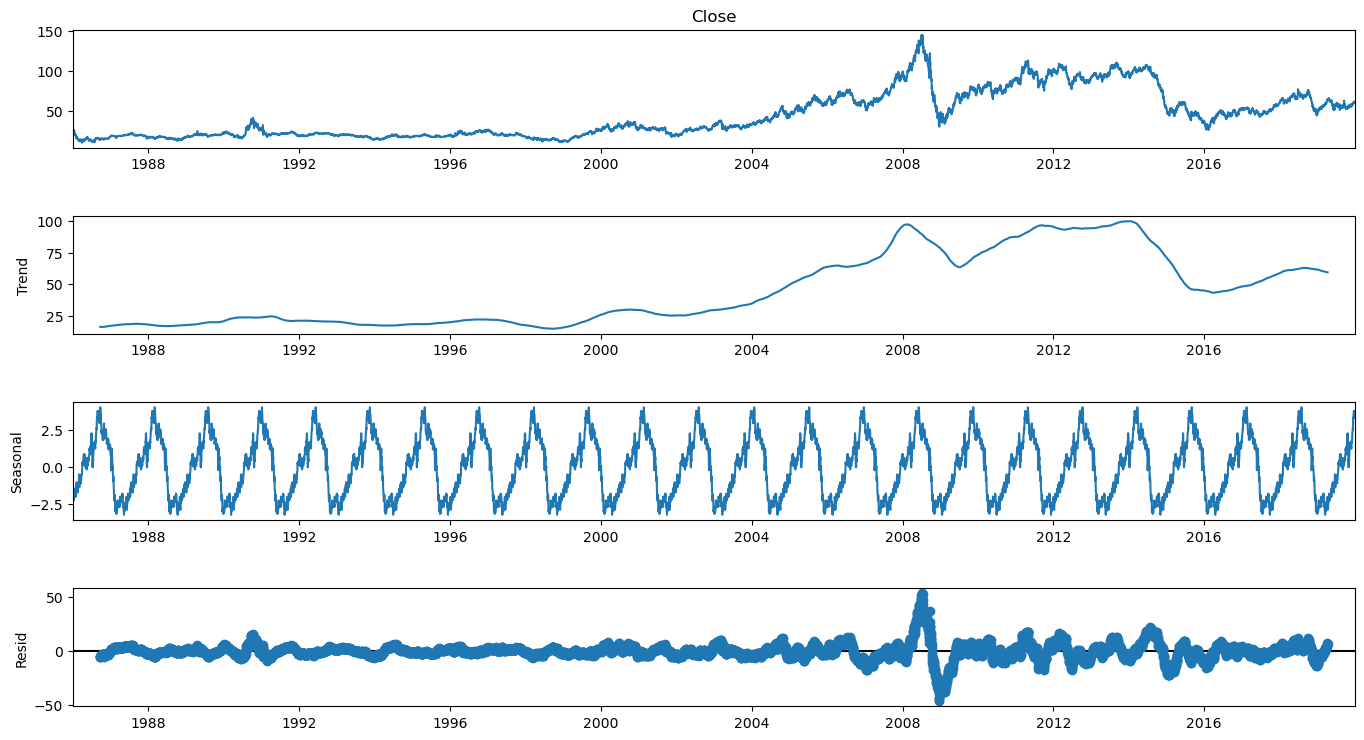

In [13]:
res = sm.tsa.seasonal_decompose(filtered_crude_d['Close'], period = 365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

#### BACKTESTING

Comparing actual market returns vs strategy returns, based on seasonality. The strategy would prefer Short positions on October, and November, and Long positions for the rest of the year. 

Losses are mitigated by abandoning the trade once price moves 2% in the opposite direction. 

In [14]:
backtest = filtered_crude_d.copy()
month_mask = (backtest['month'] == 'Oct') | (backtest['month'] == 'Nov')

backtest['signal'] = np.where(month_mask, -1, 1)

backtest['signal_actual'] = np.where(backtest['pct_change'] > 0, 1, -1)
backtest['market_returns'] = backtest['pct_change']
backtest['strategy_returns'] = backtest['market_returns'] * backtest['signal'].shift(periods = 1)
backtest['actual_returns'] = backtest['market_returns'] * backtest['signal_actual'].shift(periods = 1)

# cap drawdown at -1.5%: cutting losses once price 
backtest['filtered_strategy_returns'] = backtest['strategy_returns']
backtest['filtered_strategy_returns'][backtest['strategy_returns'] < -1.5] = -1.5


backtest = backtest.dropna()


Text(0.5, 1.0, 'Comparison of Returns')

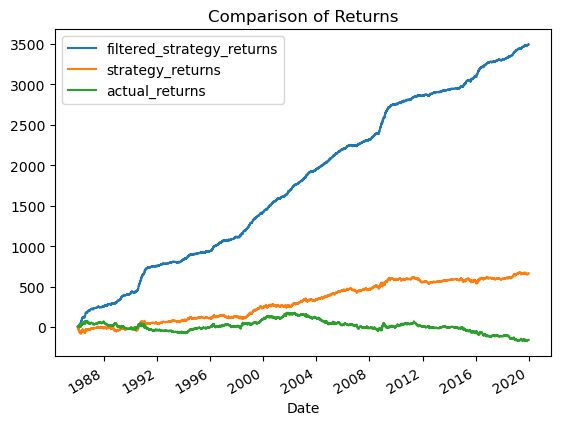

In [15]:
backtest[['filtered_strategy_returns', 'strategy_returns', 'actual_returns']].cumsum().plot()
plt.title('Comparison of Returns')

The figure above shows a brief comparison of returns for trading Crude Oil.

filtered_strategy_returns: indicates the returns of a strategy where it cuts losses at -1.5% loss. This would indicate that cutting losses immediately, significantly outperforms the times when losses are not mitigated. 

In [16]:
strat = 'filtered_strategy_returns'

drawdown = backtest.loc[backtest[strat] < 0][[strat]]
gain = backtest.loc[backtest[strat] > 0][[strat]]


(-5.0, 5.0)

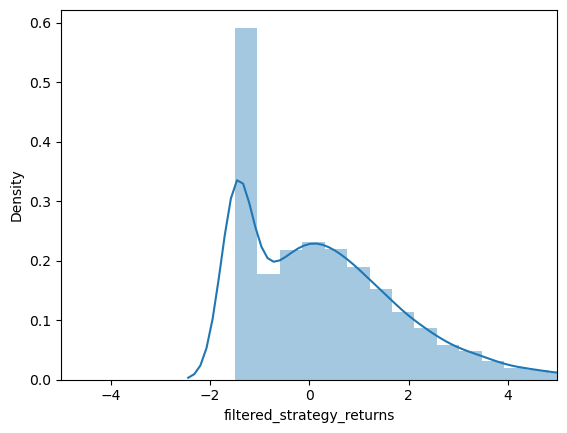

In [17]:
sns.distplot(backtest[strat])
plt.xlim((-5, 5))

#### A BRIEF SUMMARY

The current backtest configuration yields a 52% win rate with a mean gain of 1.8% and a mean loss of 1%. 

In [18]:
t = ['gain', 'loss']
g_summary = gain.describe()
l_summary = drawdown.describe()
summary = pd.concat([g_summary,l_summary], axis = 1)
summary.columns = t
summary

,gain,loss
count,4389.000000,4042.000000
mean,1.750116,-1.035828
std,1.807475,0.511311
min,0.009643,-1.500000
25%,0.590261,-1.500000
50%,1.269584,-1.256335
75%,2.295746,-0.566395
max,21.107266,-0.009428


Text(0.5, 0, 'Month')

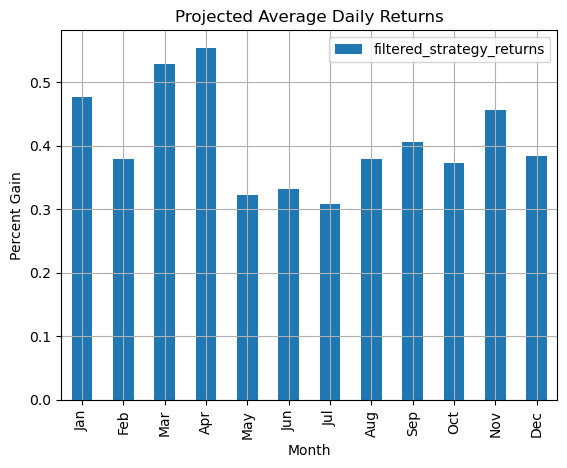

In [19]:
returns = backtest.groupby('month').mean()[[strat]].reindex(months)
returns.plot(kind = 'bar', grid = True, title = 'Projected Average Daily Returns', label = 'Returns')
plt.ylabel('Percent Gain')
plt.xlabel('Month')

Text(0.5, 0, 'Month')

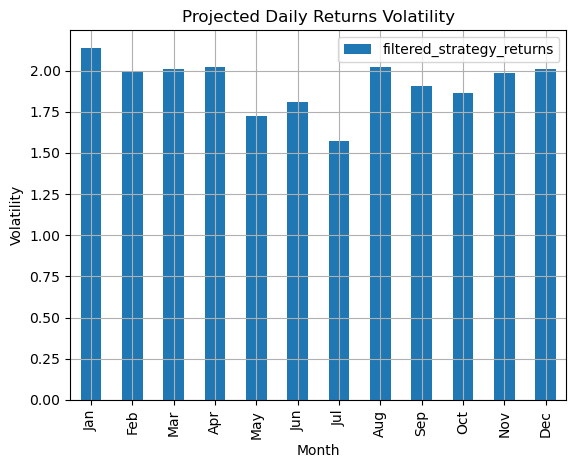

In [20]:
returns_volatility = backtest.groupby('month').std()[[strat]].reindex(months)
returns_volatility.plot(kind = 'bar', grid = True, title = 'Projected Daily Returns Volatility', label = 'Returns')
plt.ylabel('Volatility')
plt.xlabel('Month')

<AxesSubplot:title={'center':'Cumulative Monthly Returns'}, xlabel='month'>

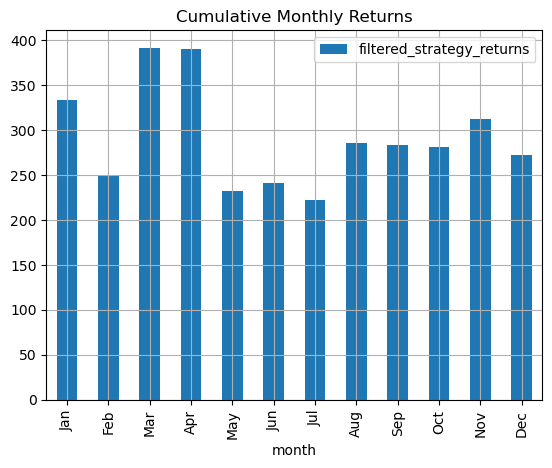

In [21]:
returns_monthly = backtest[[strat,'month']].groupby('month').sum().reindex(months)
returns_monthly.plot(kind = 'bar', grid = True, title = 'Cumulative Monthly Returns')


#### CONCLUSION 

An alpha based purely on seasonality shows promising results based on initial investigation. 

Implementing trading decisions based on this study would possibly yield profitable results over the long run. However, it is recommended to implement any additional intraday optimization or entry price selection to maximize returns. 

The main limitations, however, are black-swan events, sudden crashes, geopolitical issues, or anything outside of the normal supply and demand conditions. 